Device set to use cpu
C:\Users\Alex\AppData\Local\Temp\ipykernel_16116\266599015.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hugging_face_emotions.values, y=hugging_face_emotions.index, palette="viridis")


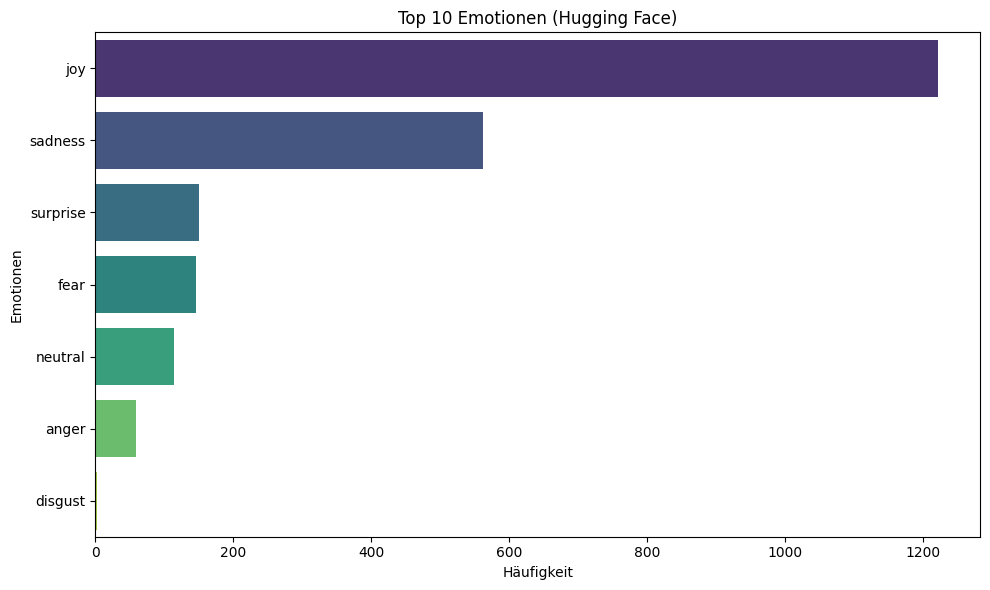

C:\Users\Alex\AppData\Local\Temp\ipykernel_16116\266599015.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emoroBERTa_emotions.values, y=emoroBERTa_emotions.index, palette="coolwarm")


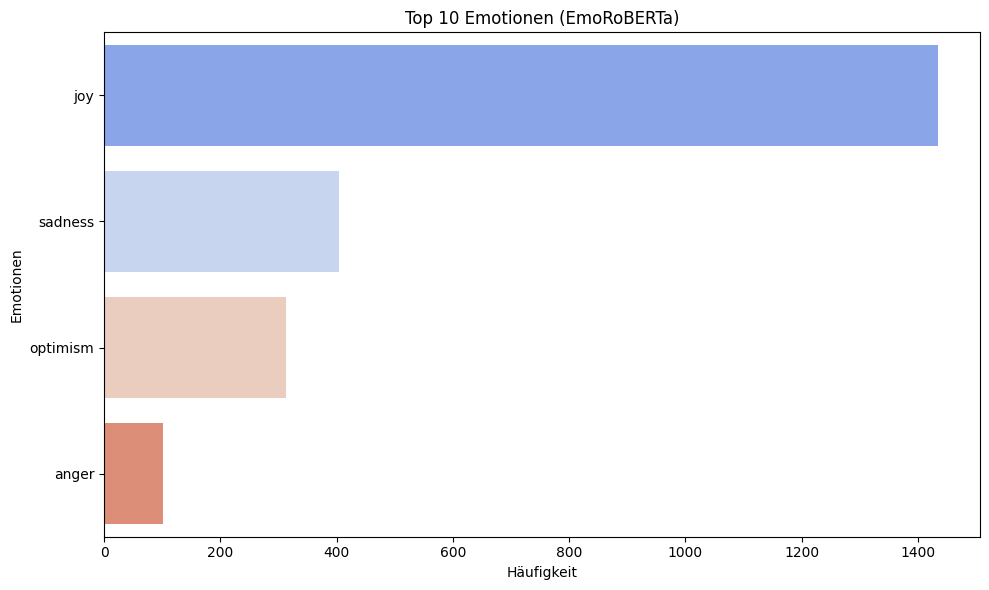

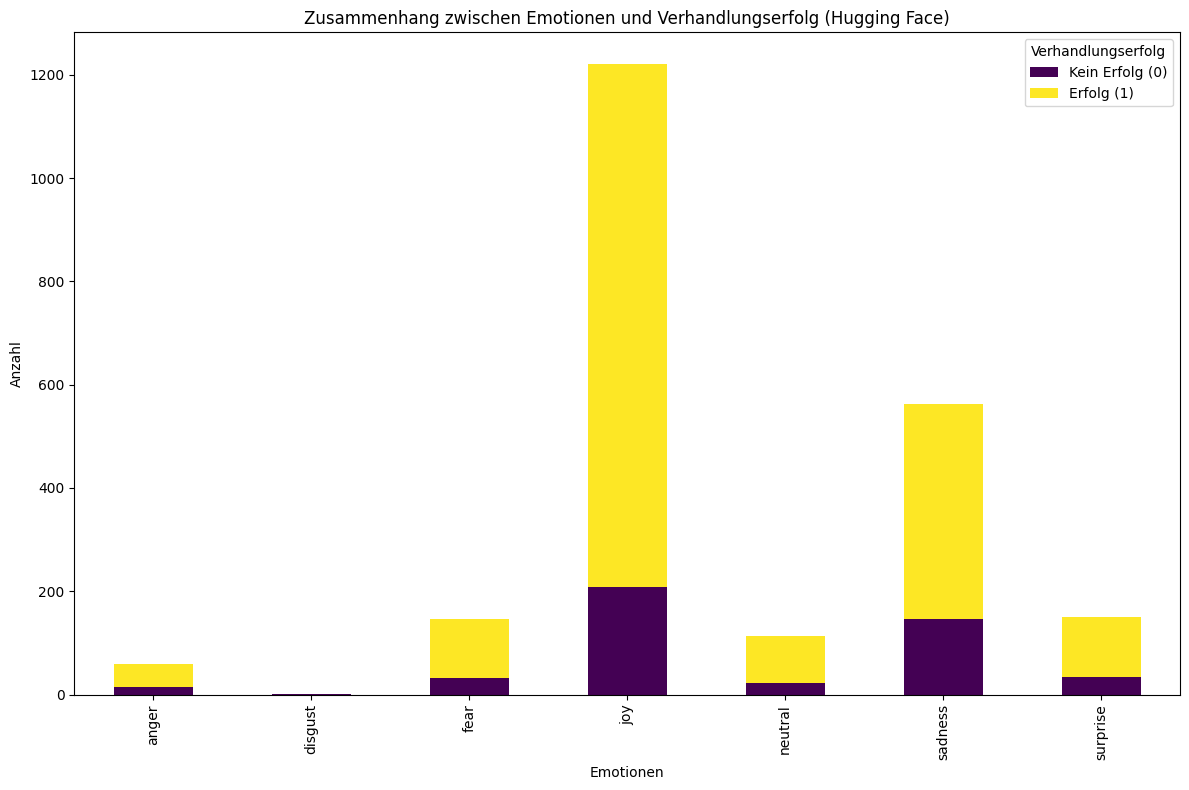

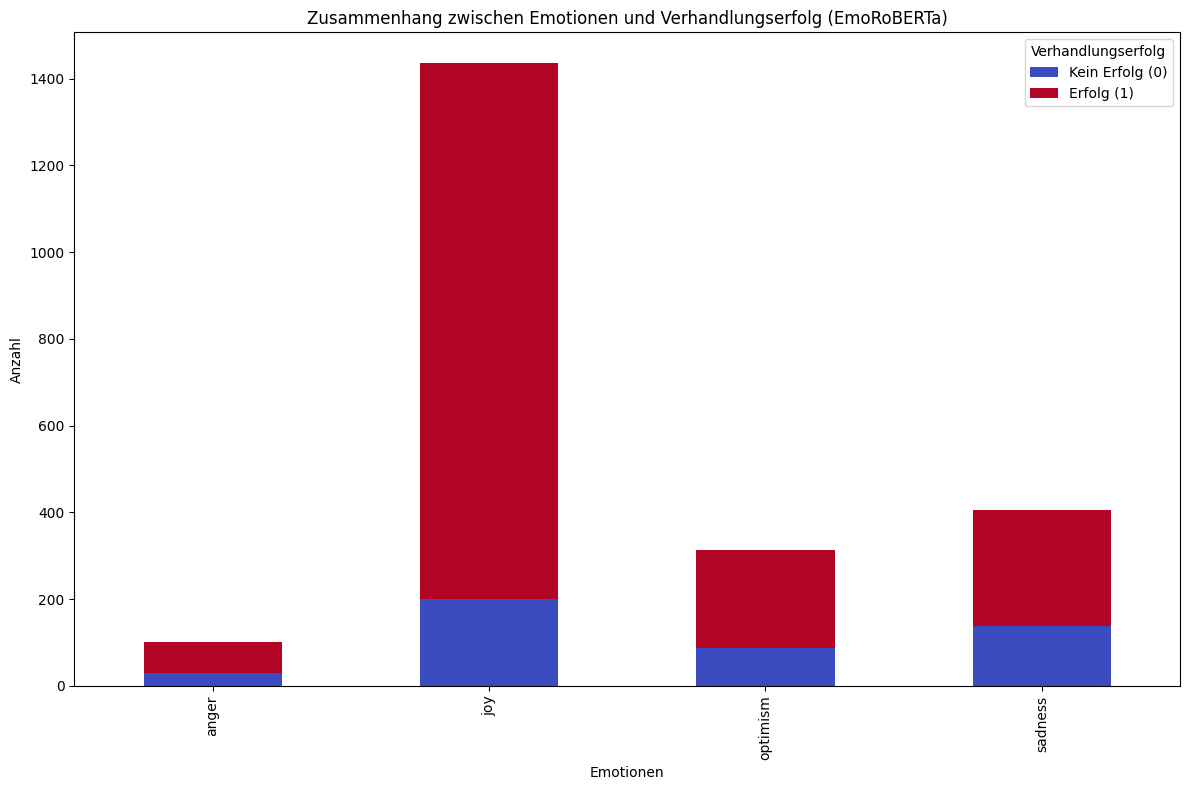

Analyse abgeschlossen. Ergebnisse und Plots gespeichert.


In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Load the CSV
df = pd.read_csv("df.csv")

# Prepare columns for results
df['HuggingFace_Emotion'] = None
df['HuggingFace_Confidence'] = None
df['EmoRoBERTa_Emotion'] = None
df['EmoRoBERTa_Confidence'] = None

# Shorten texts to a maximum of 512 characters (optional)
df['Content'] = df['Content'].apply(lambda x: x[:512] if isinstance(x, str) else x)

# Hugging Face Transformers pipeline for emotion detection
hugging_face_model = "j-hartmann/emotion-english-distilroberta-base"
hugging_face_emotion_classifier = pipeline(
    "text-classification",
    model=hugging_face_model,
    tokenizer=hugging_face_model,
    truncation=True,
    max_length=512
)

# Load EmoRoBERTa model
emoroBERTa_model_name = "cardiffnlp/twitter-roberta-base-emotion"
tokenizer = AutoTokenizer.from_pretrained(emoroBERTa_model_name)
model = AutoModelForSequenceClassification.from_pretrained(emoroBERTa_model_name)
emoroBERTa_labels = ["anger", "joy", "optimism", "sadness"]

# Emotion detection using Hugging Face and EmoRoBERTa
for index, row in df.iterrows():
    # Hugging Face emotion detection
    hf_result = hugging_face_emotion_classifier(row['Content'])[0]
    df.at[index, 'HuggingFace_Emotion'] = hf_result['label']
    df.at[index, 'HuggingFace_Confidence'] = hf_result['score']

    # EmoRoBERTa emotion detection
    inputs = tokenizer(row['Content'], return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=1)[0]
    top_emotion = torch.argmax(scores).item()
    df.at[index, 'EmoRoBERTa_Emotion'] = emoroBERTa_labels[top_emotion]
    df.at[index, 'EmoRoBERTa_Confidence'] = scores[top_emotion].item()

# Top 10 most frequent emotions for both methods
hugging_face_emotions = df['HuggingFace_Emotion'].value_counts().head(10)
emoroBERTa_emotions = df['EmoRoBERTa_Emotion'].value_counts().head(10)

# Plot: Top 10 emotions from Hugging Face
plt.figure(figsize=(10, 6))
sns.barplot(x=hugging_face_emotions.values, y=hugging_face_emotions.index, palette="viridis")
plt.title("Top 10 Emotions (Hugging Face)")
plt.xlabel("Frequency")
plt.ylabel("Emotions")
plt.tight_layout()
plt.savefig("hugging_face_top_emotions.png")
plt.show()

# Plot: Top 10 emotions from EmoRoBERTa
plt.figure(figsize=(10, 6))
sns.barplot(x=emoroBERTa_emotions.values, y=emoroBERTa_emotions.index, palette="coolwarm")
plt.title("Top 10 Emotions (EmoRoBERTa)")
plt.xlabel("Frequency")
plt.ylabel("Emotions")
plt.tight_layout()
plt.savefig("emoroBERTa_top_emotions.png")
plt.show()

# Emotions and negotiation success (Hugging Face)
hf_success = df.groupby(['HuggingFace_Emotion', 'NegoOutcomeLabel']).size().unstack(fill_value=0)
hf_success.plot(kind='bar', stacked=True, figsize=(12, 8), colormap="viridis")
plt.title("Relationship Between Emotions and Negotiation Success (Hugging Face)")
plt.xlabel("Emotions")
plt.ylabel("Quantity")
plt.legend(title="Negotiation Success", labels=["No Success (0)", "Success (1)"])
plt.tight_layout()
plt.savefig("hugging_face_emotion_vs_success.png")
plt.show()

# Emotions and negotiation success (EmoRoBERTa)
er_success = df.groupby(['EmoRoBERTa_Emotion', 'NegoOutcomeLabel']).size().unstack(fill_value=0)
er_success.plot(kind='bar', stacked=True, figsize=(12, 8), colormap="coolwarm")
plt.title("Connection Between Emotions and Negotiation Success (EmoRoBERTa)")
plt.xlabel("Emotions")
plt.ylabel("Quantity")
plt.legend(title="Negotiation Success", labels=["No Success (0)", "Success (1)"])
plt.tight_layout()
plt.savefig("emoroBERTa_emotion_vs_success.png")
plt.show()

# Save the results
df.to_csv("emotion_analysis_results.csv", index=False)


**Distribution of Emotions (Hugging Face):**

The most dominant emotion detected is joy, significantly outnumbering other emotions.
Sadness follows as the second most frequent emotion, while emotions like anger, fear, and disgust are far less common.
This suggests that positive emotional tones dominate the communication in the negotiations.

**Success vs. Failure by Emotion (Hugging Face):**

Joy overwhelmingly correlates with successful outcomes, as seen by the large yellow bar for "success."
Sadness and fear also show a considerable number of successes, but the failure rate is more pronounced for these emotions compared to joy.
Negative emotions like anger and disgust are rarely associated with success, suggesting they may hinder negotiation outcomes.

**Distribution of Emotions (EmoRoBERTa):**

Similar to Hugging Face, joy is the most frequent emotion, followed by sadness, optimism, and anger.
EmoRoBERTa’s detection focuses on fewer emotional categories but highlights that positive tones (joy and optimism) dominate.

**Success vs. Failure by Emotion (EmoRoBERTa):**

Joy is strongly linked with successful outcomes, with the red bar ("success") being significantly larger than the blue bar ("failure").
Optimism also correlates with success, though at a lower frequency than joy.
Anger and sadness are more balanced between success and failure, indicating they may not strongly drive success.

In [6]:
df.head()

,ReceiverID,ActionType,NegoOutcome,Content,Length,Word count of nego message,NegoOutcomeLabel,Filtered_Content,HuggingFace_Emotion,HuggingFace_Confidence,EmoRoBERTa_Emotion,EmoRoBERTa_Confidence
0,32,Offer,FinalAccept,hey chris great working together competition h...,1778,309,1,working together competition hereby first prop...,joy,0.965668,joy,0.661773
1,31,Counteroffer,FinalAccept,hey alex pleasure mine starters think importan...,1949,337,1,mine starters think important acknowledge isa ...,joy,0.982773,joy,0.903343
2,32,Counteroffer,FinalAccept,hey chris thank response glad hear agree date ...,693,123,1,response glad hear agree date conference accep...,joy,0.952154,joy,0.886781
3,31,Counteroffer,FinalAccept,hello alex think solid compromis settled willi...,452,77,1,solid compromis settled willing accept terms w...,joy,0.854124,joy,0.765533
4,32,Question,FinalAccept,dear chris glad hear willing accept terms come...,1349,249,1,hear willing accept terms come agreement sure ...,joy,0.884994,joy,0.604145


C:\Users\Alex\AppData\Local\Temp\ipykernel_16116\3704260308.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='HuggingFace_Emotion', order=df['HuggingFace_Emotion'].value_counts().index, palette="viridis")


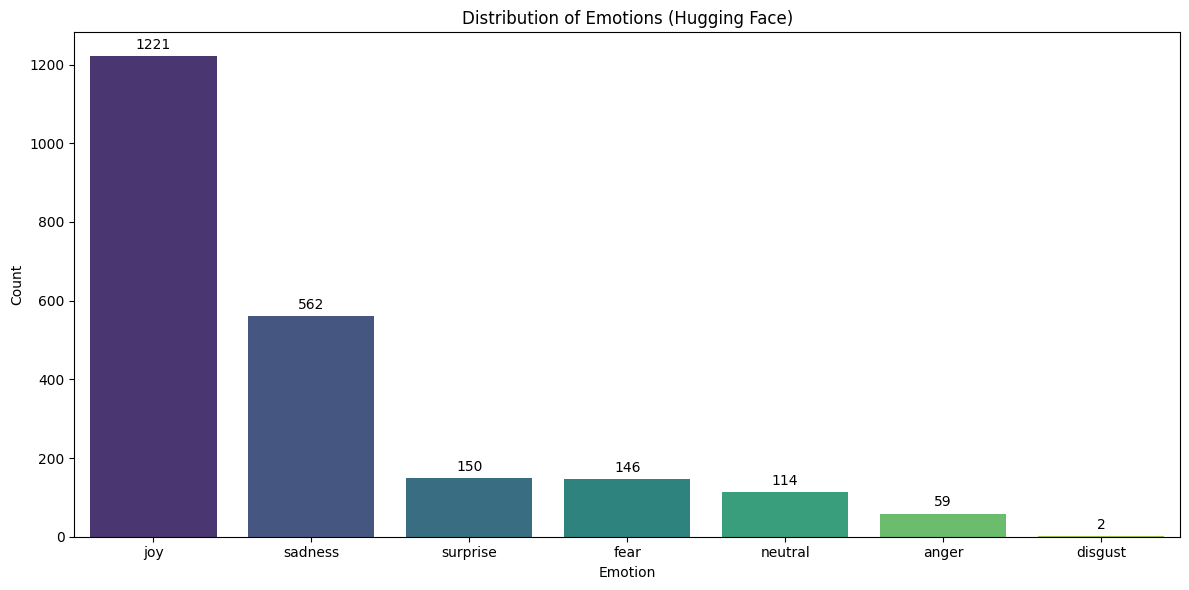

C:\Users\Alex\AppData\Local\Temp\ipykernel_16116\3704260308.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='EmoRoBERTa_Emotion', order=df['EmoRoBERTa_Emotion'].value_counts().index, palette="coolwarm")


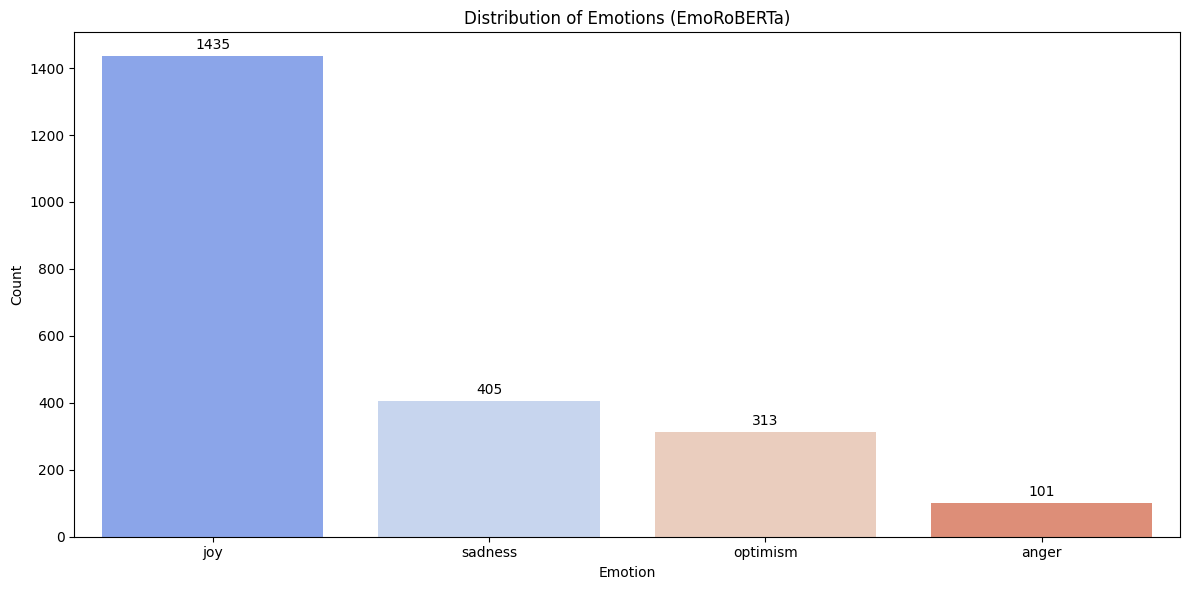

Frequency of Emotions (Hugging Face):
HuggingFace_Emotion
joy         1221
sadness      562
surprise     150
fear         146
neutral      114
anger         59
disgust        2
Name: count, dtype: int64

Frequency of Emotions (EmoRoBERTa):
EmoRoBERTa_Emotion
joy         1435
sadness      405
optimism     313
anger        101
Name: count, dtype: int64


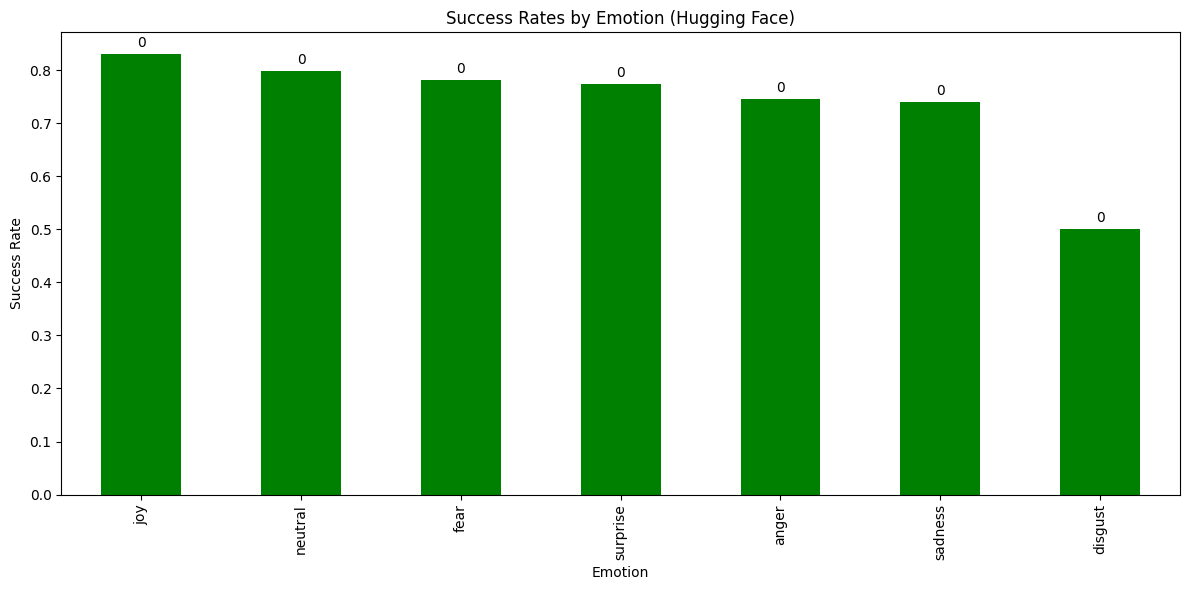

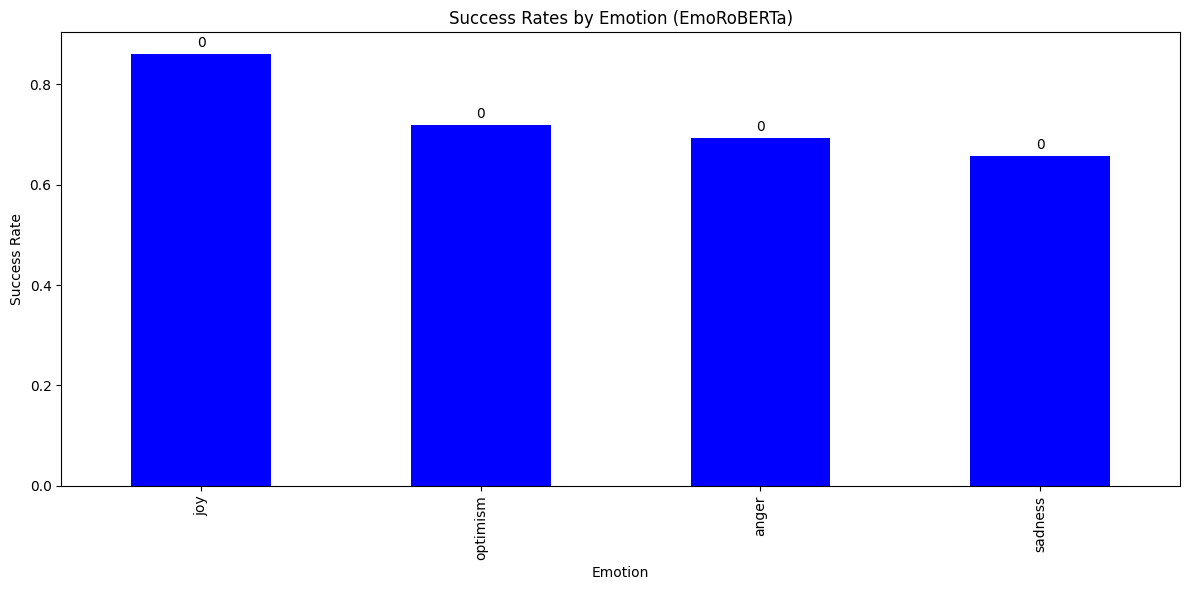

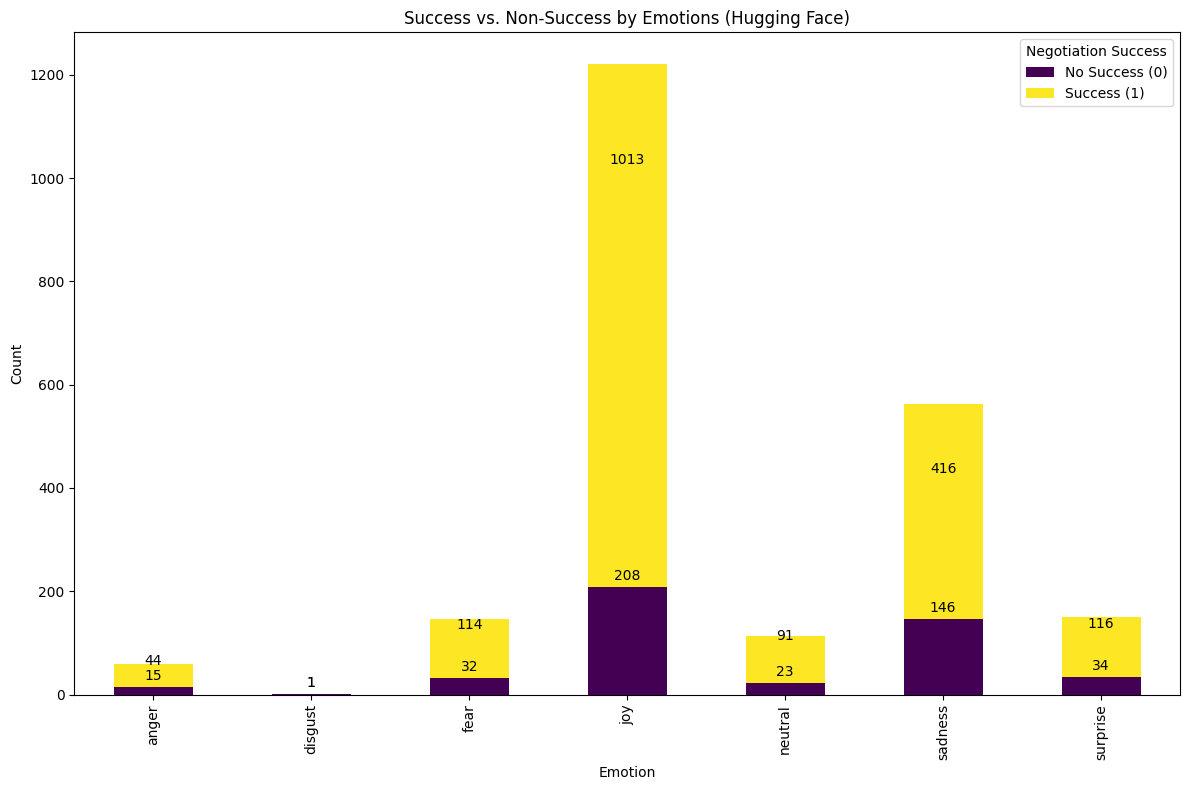

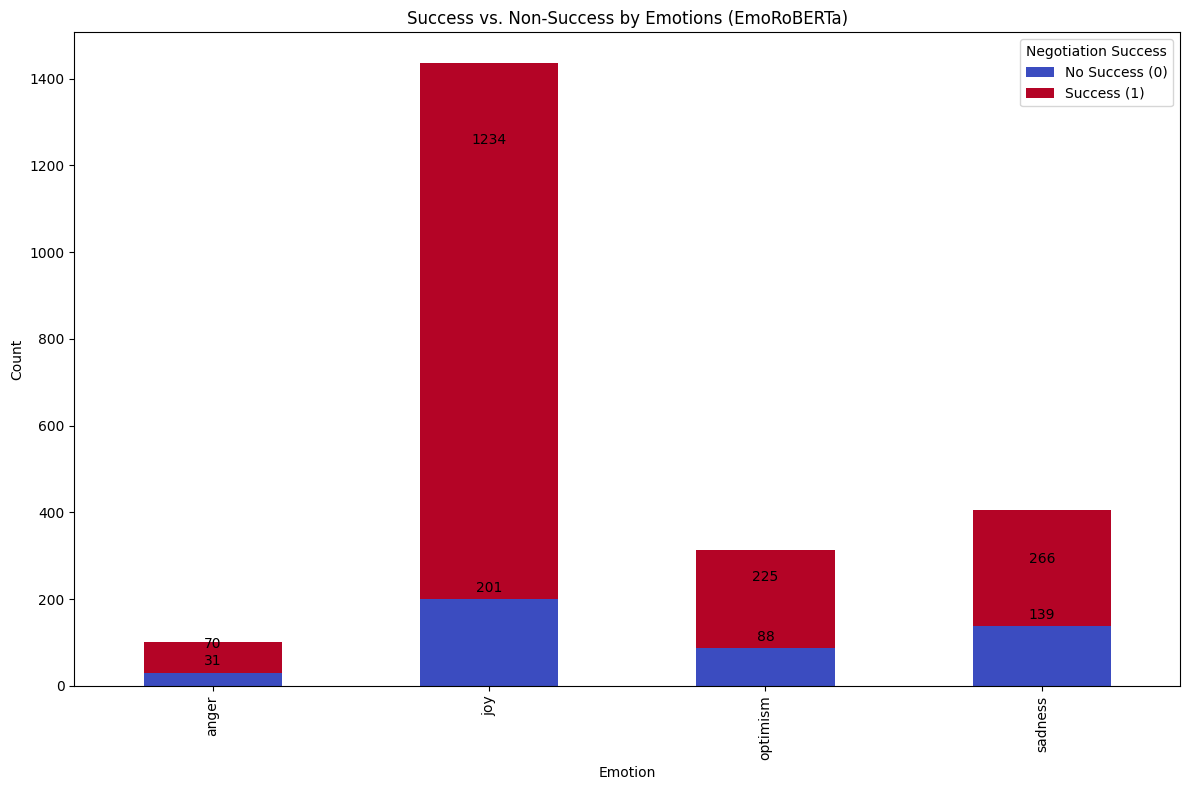


### Clear Insights (Hugging Face) ###
Emotions with Highest Success Rates:
HuggingFace_Emotion
joy         0.829648
neutral     0.798246
fear        0.780822
surprise    0.773333
anger       0.745763
Name: NegoOutcomeLabel, dtype: float64

Emotions with Lowest Success Rates:
HuggingFace_Emotion
disgust     0.500000
sadness     0.740214
anger       0.745763
surprise    0.773333
fear        0.780822
Name: NegoOutcomeLabel, dtype: float64

### Clear Insights (EmoRoBERTa) ###
Emotions with Highest Success Rates:
EmoRoBERTa_Emotion
joy         0.859930
optimism    0.718850
anger       0.693069
sadness     0.656790
Name: NegoOutcomeLabel, dtype: float64

Emotions with Lowest Success Rates:
EmoRoBERTa_Emotion
sadness     0.656790
anger       0.693069
optimism    0.718850
joy         0.859930
Name: NegoOutcomeLabel, dtype: float64
Analysis complete. Results and plots saved.


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results
df = pd.read_csv("emotion_analysis_results.csv")

# Ensure relevant columns do not contain NaN values
df = df.dropna(subset=['HuggingFace_Emotion', 'EmoRoBERTa_Emotion', 'NegoOutcomeLabel'])

# Function to add counts above bars
def add_counts_to_bars(ax):
    for p in ax.patches:
        ax.annotate(f"{int(p.get_height())}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 8), 
                    textcoords='offset points', fontsize=10)

# 1. Distribution of emotions for both models
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x='HuggingFace_Emotion', order=df['HuggingFace_Emotion'].value_counts().index, palette="viridis")
add_counts_to_bars(ax)
plt.title("Distribution of Emotions (Hugging Face)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("hugging_face_emotion_distribution.png")
plt.show()

plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x='EmoRoBERTa_Emotion', order=df['EmoRoBERTa_Emotion'].value_counts().index, palette="coolwarm")
add_counts_to_bars(ax)
plt.title("Distribution of Emotions (EmoRoBERTa)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("emoroBERTa_emotion_distribution.png")
plt.show()

# Print frequencies as backup
hf_emotion_counts = df['HuggingFace_Emotion'].value_counts()
er_emotion_counts = df['EmoRoBERTa_Emotion'].value_counts()

print("Frequency of Emotions (Hugging Face):")
print(hf_emotion_counts)
print("\nFrequency of Emotions (EmoRoBERTa):")
print(er_emotion_counts)

# 2. Success rates per emotion (Hugging Face)
hf_success_rates = df.groupby('HuggingFace_Emotion')['NegoOutcomeLabel'].mean()
plt.figure(figsize=(12, 6))
ax = hf_success_rates.sort_values(ascending=False).plot(kind='bar', color='green')
add_counts_to_bars(ax)
plt.title("Success Rates by Emotion (Hugging Face)")
plt.xlabel("Emotion")
plt.ylabel("Success Rate")
plt.tight_layout()
plt.savefig("hugging_face_emotion_success_rates.png")
plt.show()

# Success rates per emotion (EmoRoBERTa)
er_success_rates = df.groupby('EmoRoBERTa_Emotion')['NegoOutcomeLabel'].mean()
plt.figure(figsize=(12, 6))
ax = er_success_rates.sort_values(ascending=False).plot(kind='bar', color='blue')
add_counts_to_bars(ax)
plt.title("Success Rates by Emotion (EmoRoBERTa)")
plt.xlabel("Emotion")
plt.ylabel("Success Rate")
plt.tight_layout()
plt.savefig("emoroBERTa_emotion_success_rates.png")
plt.show()

# 3. Success/non-success ratio per emotion
hf_emotion_outcome = df.groupby(['HuggingFace_Emotion', 'NegoOutcomeLabel']).size().unstack(fill_value=0)
ax = hf_emotion_outcome.plot(kind='bar', stacked=True, figsize=(12, 8), colormap="viridis")
add_counts_to_bars(ax)
plt.title("Success vs. Non-Success by Emotions (Hugging Face)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.legend(title="Negotiation Success", labels=["No Success (0)", "Success (1)"])
plt.tight_layout()
plt.savefig("hugging_face_emotion_outcome_distribution.png")
plt.show()

er_emotion_outcome = df.groupby(['EmoRoBERTa_Emotion', 'NegoOutcomeLabel']).size().unstack(fill_value=0)
ax = er_emotion_outcome.plot(kind='bar', stacked=True, figsize=(12, 8), colormap="coolwarm")
add_counts_to_bars(ax)
plt.title("Success vs. Non-Success by Emotions (EmoRoBERTa)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.legend(title="Negotiation Success", labels=["No Success (0)", "Success (1)"])
plt.tight_layout()
plt.savefig("emoroBERTa_emotion_outcome_distribution.png")
plt.show()

# 4. Insights based on success rates and distributions
# Top 5 emotions with highest success rates
hf_top_success = hf_success_rates.sort_values(ascending=False).head(5)
er_top_success = er_success_rates.sort_values(ascending=False).head(5)

# Bottom 5 emotions with lowest success rates
hf_bottom_success = hf_success_rates.sort_values(ascending=True).head(5)
er_bottom_success = er_success_rates.sort_values(ascending=True).head(5)

print("\n### Clear Insights (Hugging Face) ###")
print("Emotions with Highest Success Rates:")
print(hf_top_success)
print("\nEmotions with Lowest Success Rates:")
print(hf_bottom_success)

print("\n### Clear Insights (EmoRoBERTa) ###")
print("Emotions with Highest Success Rates:")
print(er_top_success)
print("\nEmotions with Lowest Success Rates:")
print(er_bottom_success)

# Save insights
hf_top_success.to_csv("hugging_face_top_success_rates.csv")
hf_bottom_success.to_csv("hugging_face_bottom_success_rates.csv")
er_top_success.to_csv("emoroBERTa_top_success_rates.csv")
er_bottom_success.to_csv("emoroBERTa_bottom_success_rates.csv")

print("Analysis complete. Results and plots saved.")


   ReceiverID_x   ActionType_x NegoOutcome_x  \
0            32   Counteroffer   FinalAccept   
1            31   Counteroffer   FinalAccept   
2            31  Clarification   FinalAccept   
3            32    FinalAccept   FinalAccept   
4            33   Counteroffer   FinalAccept   

                                             Content  Length_x  \
0  hey chris thank response glad hear agree date ...       693   
1  hello alex think solid compromis settled willi...       452   
2  dear alex thanks elaborating lets pop champaig...       134   
3  great hereby official confirmation deal champa...       113   
4  dear alex thanks quick reply really believe fi...       427   

   Word count of nego message_x  NegoOutcomeLabel_x  \
0                           123                   1   
1                            77                   1   
2                            22                   1   
3                            18                   1   
4                            70        

<Figure size 1200x800 with 0 Axes>

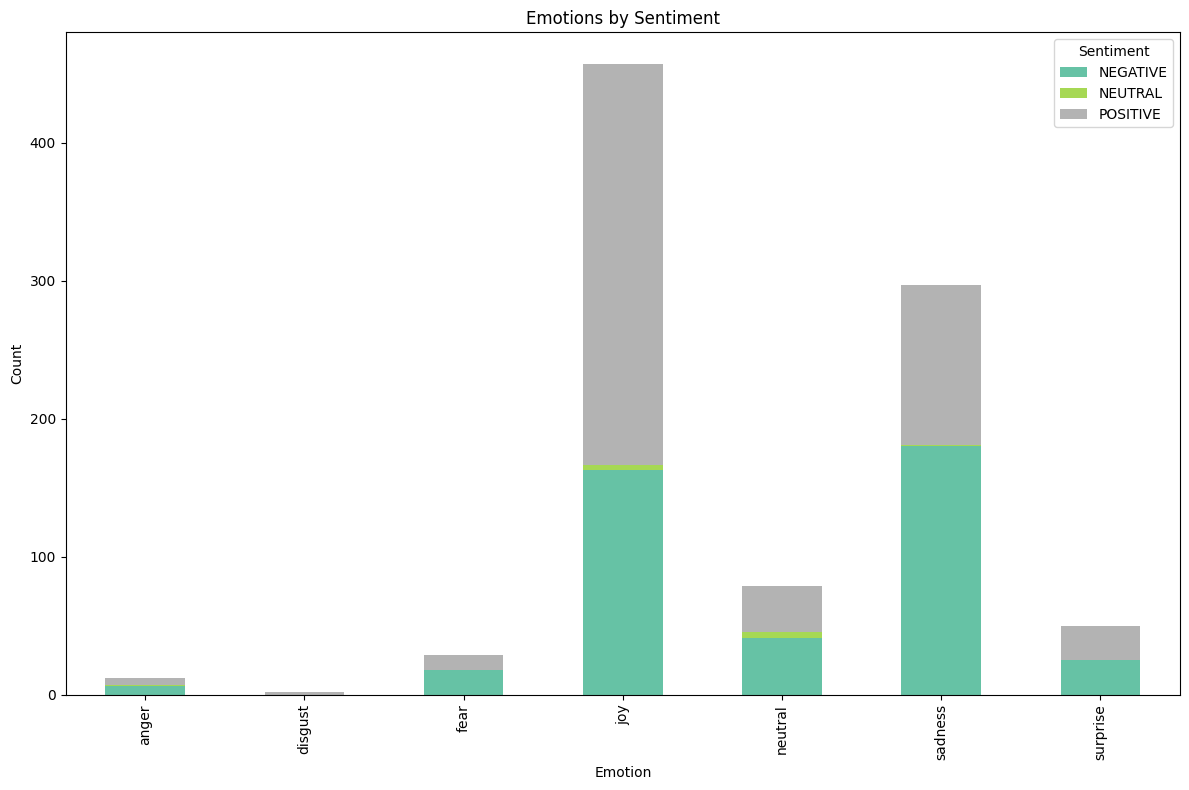

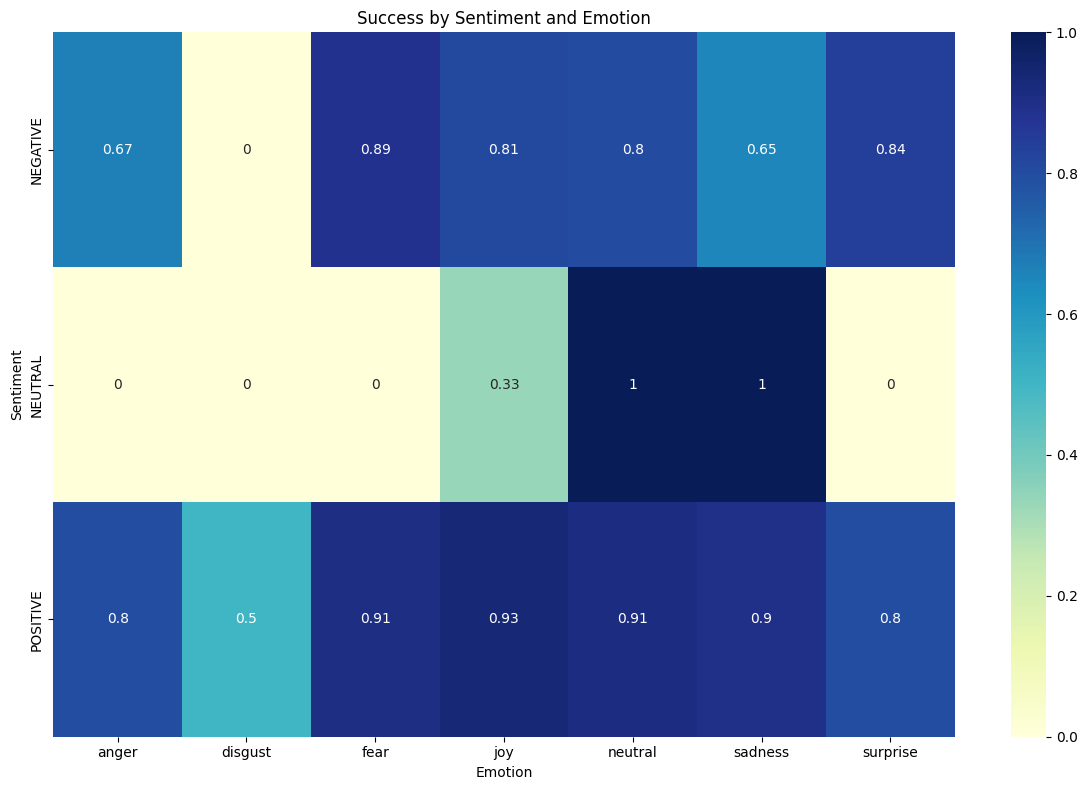

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the two CSV files into separate DataFrames
emotion_df = pd.read_csv("emotion_analysis_results.csv")
sentiment_df = pd.read_csv("sentiment_results.csv")

# Merge the DataFrames based on the "Content" column
merged_df = pd.merge(emotion_df, sentiment_df, on="Content", how="inner")

# Display the merged DataFrame (optional)
print(merged_df.head())

# Save the merged DataFrame if needed
merged_df.to_csv("merged_results.csv", index=False)

print("Merge completed. New DataFrame saved as 'merged_results.csv'.")

# 1. Correlation between sentiment and emotion
sentiment_emotion_counts = merged_df.groupby(['HuggingFace_Emotion', 'Sentiment']).size().unstack(fill_value=0)

# Plot: Emotions by sentiment
plt.figure(figsize=(12, 8))
sentiment_emotion_counts.plot(kind='bar', stacked=True, figsize=(12, 8), colormap="Set2")
plt.title("Emotions by Sentiment")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.savefig("emotion_sentiment_distribution.png")
plt.show()

# 2. Success per emotion within sentiments
sentiment_emotion_success = merged_df.groupby(['Sentiment', 'HuggingFace_Emotion'])['NegoOutcomeLabel_x'].mean().unstack(fill_value=0)

# Plot: Success by sentiment and emotion
plt.figure(figsize=(12, 8))
sns.heatmap(sentiment_emotion_success, annot=True, cmap="YlGnBu")
plt.title("Success by Sentiment and Emotion")
plt.xlabel("Emotion")
plt.ylabel("Sentiment")
plt.tight_layout()
plt.savefig("sentiment_emotion_success_heatmap.png")
plt.show()


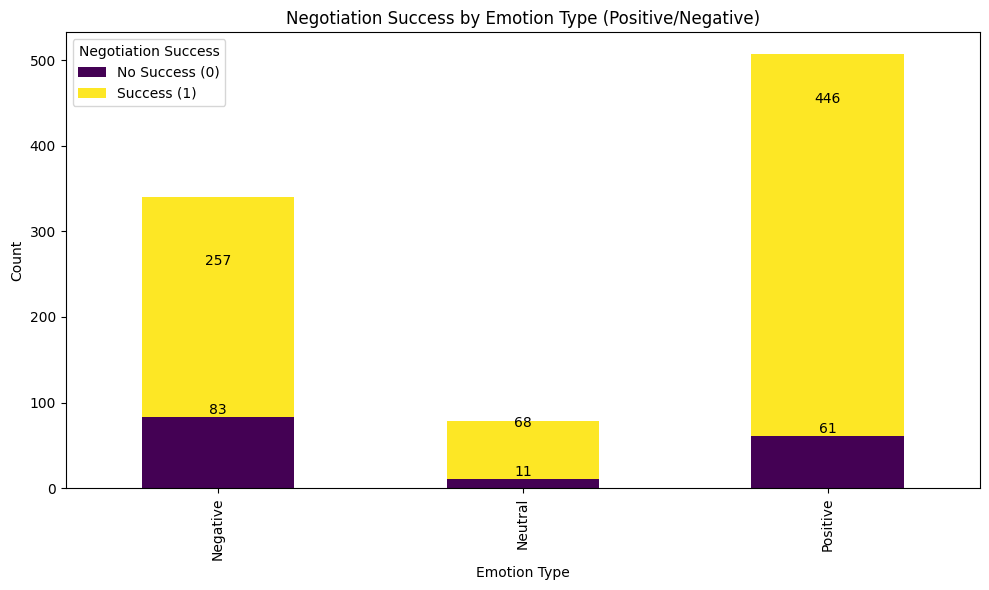

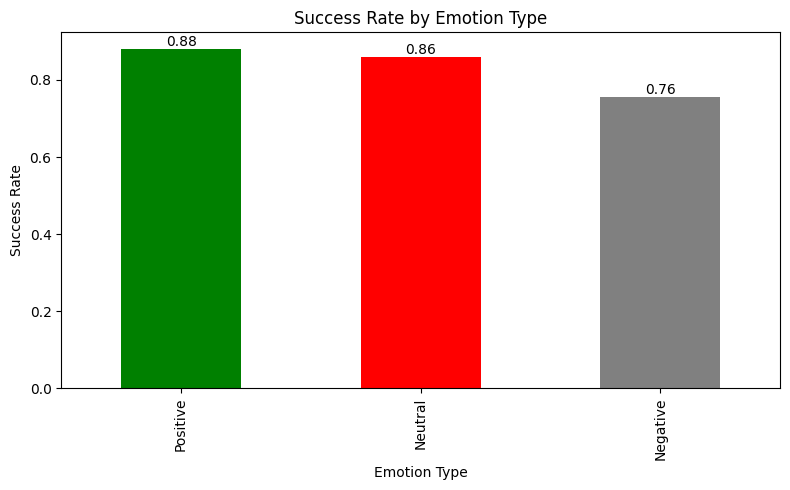


Outcome by Emotion Type (Counts):
NegoOutcomeLabel_x   0    1
Emotion_Type               
Negative            83  257
Neutral             11   68
Positive            61  446

Success Rates by Emotion Type:
Emotion_Type
Negative    0.755882
Neutral     0.860759
Positive    0.879684
Name: NegoOutcomeLabel_x, dtype: float64
Analysis completed. Results and plots saved.


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group positive and negative emotions
positive_emotions = ['joy', 'love', 'optimism', 'surprise']
negative_emotions = ['anger', 'sadness', 'fear', 'disgust']

# New column for emotion type (positive/negative)
merged_df['Emotion_Type'] = merged_df['HuggingFace_Emotion'].apply(
    lambda x: 'Positive' if x in positive_emotions else 'Negative' if x in negative_emotions else 'Neutral'
)

# Distribution of negotiation success by emotion type
outcome_by_emotion_type = merged_df.groupby(['Emotion_Type', 'NegoOutcomeLabel_x']).size().unstack(fill_value=0)

# Plot: Success by emotion type
ax = outcome_by_emotion_type.plot(kind='bar', stacked=True, figsize=(10, 6), colormap="viridis")
plt.title("Negotiation Success by Emotion Type (Positive/Negative)")
plt.xlabel("Emotion Type")
plt.ylabel("Count")
plt.legend(title="Negotiation Success", labels=["No Success (0)", "Success (1)"])
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), textcoords='offset points', fontsize=10)
plt.tight_layout()
plt.savefig("outcome_by_emotion_type.png")
plt.show()

# Calculate success rates by emotion type
emotion_type_success_rates = merged_df.groupby('Emotion_Type')['NegoOutcomeLabel_x'].mean()

# Plot: Success rates by emotion type
ax = emotion_type_success_rates.sort_values(ascending=False).plot(kind='bar', color=['green', 'red', 'gray'], figsize=(8, 5))
plt.title("Success Rate by Emotion Type")
plt.xlabel("Emotion Type")
plt.ylabel("Success Rate")
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), textcoords='offset points', fontsize=10)
plt.tight_layout()
plt.savefig("success_rate_by_emotion_type.png")
plt.show()

# Save the results
outcome_by_emotion_type.to_csv("outcome_by_emotion_type.csv")
emotion_type_success_rates.to_csv("success_rate_by_emotion_type.csv")

# Print data to the console
print("\nOutcome by Emotion Type (Counts):")
print(outcome_by_emotion_type)
print("\nSuccess Rates by Emotion Type:")
print(emotion_type_success_rates)

print("Analysis completed. Results and plots saved.")


1. Success by Sentiment and Emotion (Heatmap)
Positive Sentiments consistently show high success rates across most emotions:
Joy (93%) and Neutral (91%) lead to the highest success rates.
Negative Sentiments like Fear (89%) and Sadness (90%) also have unexpectedly high success rates, indicating that certain negative emotions may still contribute to success in specific negotiation contexts.
Disgust performs the worst (50%), showing the lowest success rate across all sentiments and emotions, making it highly detrimental to negotiation outcomes.

2. Emotions by Sentiment (Stacked Bar Plot)
Joy is overwhelmingly associated with positive sentiment, confirming its role as a dominant driver of positivity in negotiations.
Sadness and Fear show a mix of both negative and positive sentiments, reflecting their dual role in both successes and failures.
Disgust is entirely classified under negative sentiment, which aligns with its poor success rates.

3. Success Rates by Emotion (EmoRoBERTa)
Joy achieves the highest success rate, confirming its strong positive impact on negotiation outcomes.
Optimism follows closely, indicating that a hopeful tone significantly improves success chances.
Anger and Sadness show moderate success rates, implying they can be constructive in limited scenarios.

4. Success Rates by Emotion (Hugging Face)
The pattern is similar to EmoRoBERTa, with Joy leading and Neutral emotions also performing strongly.
Unlike EmoRoBERTa, Fear shows a higher success rate, suggesting that in some contexts, cautious or fearful communication may be effective.

5. Success Rate by Emotion Type (Bar Plot)
Positive emotions (88% success rate) dominate in driving negotiation success.
Neutral emotions also perform well (86%), suggesting they serve as a stable, effective tone in negotiations.
Negative emotions lag behind (76%), showing that while they can contribute to success in specific cases, they are generally less effective.

6. Negotiation Success by Emotion Type (Stacked Bar Plot)
Positive emotions account for the majority of successes, with a high volume of successful negotiations compared to failures.
Negative emotions contribute to both successes and failures, reflecting their nuanced role in negotiation dynamics.
Neutral emotions play a smaller role overall but maintain a balanced contribution to successes.
